In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
import numpy as np

from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [3]:
import genjax
console = genjax.pretty(show_locals=False)

In [4]:
import json


fname = "test_env_4.json"
with open(fname, 'r') as f:
    env_data = json.load(f)

env_data.keys()

dict_keys(['env_name', 'paths', 'verts', 'clutter_verts', 'segs', 'clutter_segs'])

In [5]:
intrinsics = b.Intrinsics(
    height=1,
    width=50,
    fx=10.0, fy=1.0,
    cx=25.0, cy=0.0,
    near=0.01, far=20.0
)
b.setup_renderer(intrinsics)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)


In [6]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7000/static/


In [7]:
import trimesh

014e6d1cee6e6a1297a78f761fbc6700.json


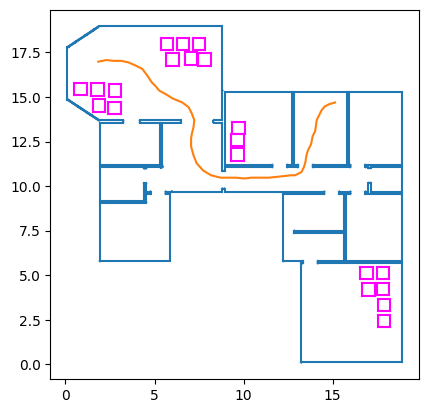

In [8]:
print(env_data["env_name"])
# print(data["paths"]);
# print(data["verts"]);

segs = jnp.array(env_data["segs"])
boxes = jnp.array(env_data["clutter_segs"])
path = jnp.array(env_data["paths"][0]) 
# points = jnp.array(env_data["verts"])
# plt.plot(points[:,0],points[:,1])
# paths = jnp.array(env_data["paths"][0])
# plt.plot(paths[:,0], paths[:,1])


# -------------------
plt.gca().set_aspect(1.0)
plt.plot(segs[:,[0,2]].T, segs[:,[1,3]].T, c="C0");
for segs_ in boxes:
    plt.plot(segs_[:,[0,2]].T, segs_[:,[1,3]].T, c="magenta");
plt.plot(path[:,0], path[:,1], c="C1");

In [9]:
pieces = []

for s in segs:
    x = s[:2]
    y = s[2:]
    p = b.t3d.transform_from_pos(
            jnp.concatenate([(x + y)/2 , jnp.array([0.])])
    )

    dimensions = np.array(jnp.concatenate([jnp.abs(x - y) , jnp.array([1.0])]))

    piece = trimesh.creation.box(dimensions, p)

    # print("==============================")
    # print("point_1 ", point_1)
    # print("point_2 ", point_2)
    # print("pose ", p)
    # print("dimensions ", dimensions)
    # print(piece.vertices)
    pieces.append(piece)

In [10]:
final_mesh = trimesh.util.concatenate(pieces)
b.show_trimesh("1", final_mesh)

In [11]:
b.setup_renderer(intrinsics)
b.RENDERER.add_mesh(final_mesh) 

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (64, 32, 1024)


In [12]:
pose_from_position = lambda p: b.t3d.transform_from_rot_and_pos(b.t3d.rotation_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), -jnp.pi/2), jnp.concatenate([p, jnp.array([0.0])]))
pose_sequence = jax.vmap(pose_from_position)(path)

In [13]:
b.show_pose("2", pose_sequence[10])

In [34]:
img = b.RENDERER.render_single_object(
    b.t3d.inverse_pose(pose_sequence[10]), 
    jnp.int32(0) # index of mesh you want to render
)
img.shape

(1, 50, 4)

In [15]:
cloud = b.t3d.unproject_depth_jit(img[:,:,2], intrinsics)
b.show_cloud("reproject", b.t3d.apply_transform(cloud, pose_sequence[10]).reshape(-1,3))

[<matplotlib.lines.Line2D object at 0x7fdb306c2d30>]

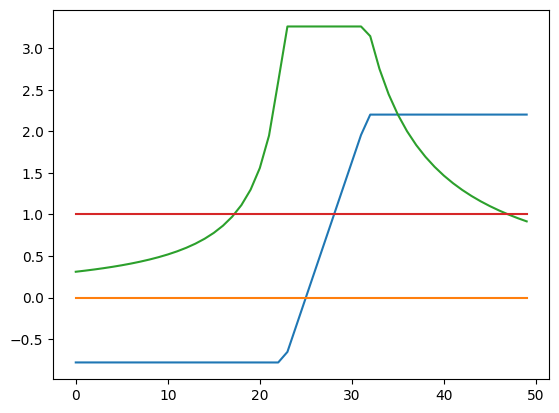

In [36]:
# plt.imshow(img[0,:,:])
plt.plot(img[0,:,0]) # x
plt.plot(img[0,:,1]) # y
plt.plot(img[0,:,2]) # z
plt.plot(img[0,:,3]) # segmentation mask, 0 - hit nothing, 1 - idx 0, 2 - idx 1 , ... , i - idx i-1

In [ ]:
jnp.swapaxes(img, 3,2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 50, 4)


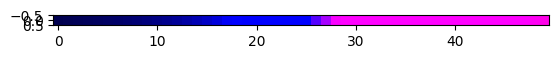

In [37]:
img_ = jnp.stack([
    img[:,:,0],
    img[:,:,1],
    img[:,:,3],
    img[:,:,2],
], axis=2)
print(img_.shape)
# plt.imshow(img_[:,:,:])
plt.imshow(img[:,:,:])

In [38]:
import genjax
from genjax import GenerativeFunction, ChoiceMap, Selection, trace

# Pretty printing.
console = genjax.pretty(width=80)

# Reproducibility.
key = jax.random.PRNGKey(314159)

```julia
#nbx
# This works on GPU only
@gen function sensor_model_GPU(p, segs, w, s_noise, outlier, outlier_vol, zmax=100.0)
    segs_ = CuArray(stack(Vector.(segs)))
    p_    = CuArray(Vector(p))
    ps_   = reshape(p_, 1, 3)

    zs_      = cast_cu(ps_, segs_; fov=_fov)
    as_      = CuArray(_as)
    y_tilde_ = get_2d_mixture_components(zs_, as_, w)[1,:,:,:]

    x ~ sensordist_2dp3(y_tilde_, s_noise, outlier, outlier_vol)    
    return x
end;
```

```julia
"""
    u = control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)

Prior over what action the agent will take next.
"""
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;


"""
    p = pose_prior_model(p::Union{Pose,Tuple}, x_noise=0.25, hd_noise=45.)

Takes a pose or a bounding box and returns a pose sampled from a prior.
"""
@gen function pose_prior_model(p::Union{Pose,Tuple}, x_noise=0.25, hd_noise=45/360*2π)
    # Todo: better signature would be to ask if p is pose or a bounding box
    if typeof(p) == Pose
        x  ~ diagnormal(p.x, [x_noise, x_noise])
        hd ~ normal(p.hd, hd_noise)
    else
        x  ~ mvuniform(p...)
        hd ~ uniform(0,2π)
    end

    return Pose(x, hd)
end;


"""
    q = motion_model(p, u, x_noise, hd_noise)

Sample a new pose `q` given the previous pose `p`, 
some control data `u = Control(dx, dhd)`, and noise levels
`x_noise` and `hd_noise`.
"""
@gen function motion_model(p, u, x_noise, hd_noise)
    dx, dhd = u.dx, u.dhd
    x   ~ diagnormal(p.x  + dx , [x_noise, x_noise])
    hd  ~ normal(p.hd + dhd, hd_noise)
    return Pose(x, hd)
end;


#nbx
@gen function slam_kernel(t, state, m, us, x_noise, hd_noise, w, s_noise, outlier, outlier_vol)
    
    p,_ = state
    u = us[t]

    p  = {:pose}   ~ motion_model(p, u, x_noise, hd_noise)
    x  = {:sensor} ~ sensor_model(p, m, w, s_noise, outlier, outlier_vol)
    
    state = (p, x)
return state
end

slam_chain = Gen.Unfold(slam_kernel)
Gen.@load_generated_functions



#nbx
@gen (static) function static_slam_model(T, 
        m,
        us, 
        p0, x0_noise, hd0_noise,  
        x_noise, hd_noise, 
        w, s_noise, outlier, outlier_vol)
    
    # Start the Markov chain; 
    # No motion, just the prior
    p  = { :pose   } ~ pose_prior_model(p0, x0_noise, hd0_noise)
    x  = { :sensor } ~ sensor_model(p, m, w, s_noise, outlier, outlier_vol) # GPU accelerated
    
    # Unfold the MArkov chain
    chain ~ slam_chain(T, (p, x), m, us, 
        x_noise, hd_noise, 
        w, s_noise, outlier, outlier_vol)
    
    return [(p,x);chain]
end

Gen.@load_generated_functions
```

In [42]:
from genjax.generative_functions.distributions import ExactDensity
from dataclasses import dataclass

@dataclass
class ImageLikelihood(ExactDensity):
    def sample(self, key, img, variance, outlier_prob, outlier_volume):
        return img

    def logpdf(self, image, s, variance, outlier_prob, outlier_volume):
        return b.threedp3_likelihood(image, s, variance, outlier_prob, outlier_volume,5)

image_likelihood = ImageLikelihood()

```julia
"""
    u = control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)

Prior over what action the agent will take next.
"""
@gen function control_prior_model(dx_noise=0.25, dhd_noise=45/360*2π)
    dx  ~ diagnormal([0;0], [dx_noise, dx_noise])
    dhd ~ normal(0, dhd_noise)
    return Control(dx, dhd)
end;
```

In [50]:
?genjax.generative_functions.distributions.mv_normal

Signature:   genjax.generative_functions.distributions.mv_normal(*args, **kwargs) -> genjax._src.generative_functions.builtin.builtin_gen_fn.DeferredGenerativeFunctionCall
Type:        MultivariateNormal
String form: MultivariateNormal()
File:        ~/genjax/src/genjax/_src/generative_functions/distributions/scipy/multivariate_normal.py
Docstring:   MultivariateNormal()

In [70]:
# normal = genjax.generative_functions.distributions.normal()
# normal.sample(key, 0,1)
# genjax.generative_functions.distributions.normal(key, 0,1)

key = jax.random.PRNGKey(314159)
v = genjax.normal.sample(key, 0.0, 1.0)
print(console.render(v))

genjax.mv_normal.sample(key, jnp.zeros(2), jnp.eye(2))

```raw
-0.62537825
```


Array([-0.49884072,  0.8985987 ], dtype=float32)

In [154]:
PI = jnp.pi
TWO_PI = 2.0 * PI


@genjax.gen
def control_prior_model(dx_noise=0.25, dhd_noise=45/360*TWO_PI):
    
    dx  = genjax.mv_normal(jnp.zeros(2), jnp.eye(2)) @ "dx"
    dhd = genjax.normal(jnp.zeros(2), jnp.eye(2)) @ "dhd"

    return (dx, dhd)


key, tr = control_prior_model.simulate(key, (0.25, 45/360*TWO_PI))



In [153]:
@genjax.gen
def motion_model(p, u, x_noise, hd_noise):
    dx, dhd = u[:2],u[3]
    
    x  = genjax.mv_normal(p[:2] + dx, x_noise*jnp.eye(2)) @ "x"
    hd = genjax.normal(p[3] + dhd, hd_noise)              @ "hd"

    return jnp.array([x[0],x[1],hd])

key, tr = motion_model.simulate(key, (ps[1], us[1], 0.001, 0.1/360*TWO_PI))
tr["x"], ps[2]

(
    Array([14.579575, 14.469172], dtype=float32),
    Array([14.551785 , 14.469523 , -2.2455373], dtype=float32)
)

In [45]:
@genjax.gen
def sensor(p, i=0):
    variance      = genjax.distributions.tfp_uniform(0.00001, 0.1)   @ "variance"
    outlier_prob  = genjax.distributions.tfp_uniform(0.00001, 0.001) @ "outlier_prob"
    
    img = b.RENDERER.render_single_object(b.t3d.inverse_pose(p), jnp.int32(i))
    obs = image_likelihood(img, variance, outlier_prob, 100.0) @ "image"

    return obs,

In [134]:
xs   = path
dxs  = xs[1:] - xs[:-1]
hds  = jnp.arctan2(dxs[:,1], dxs[:,0])
dhds = hds[1:] - hds[:-1]

xs  = xs[:len(hds)]
dxs = dxs[:len(dhds)]


ps = jnp.concatenate([xs, hds[:,None]], axis=1)
us = jnp.concatenate([dxs, dhds[:,None]], axis=1)

print(ps.shape, us.shape)

(50, 3) (49, 3)


```julia
        us[t-2]     us[t-1]
         |           |
...  --> ps[t-1] --> ps[t]
         |           |
        zs[t-1]     zs[t]
         |          /
        renderer 
```

In [97]:


x = pose_sequence[0][:2,3]
pose_sequence[0][:3,:3]@jnp.array([0.0, 0.0, 1.0])
jnp.arctan

Array([ 0.000000e+00,  1.000000e+00, -4.371139e-08], dtype=float32)

In [ ]:
pose_from_position_hd = lambda position, hd: b.t3d.transform_from_rot_and_pos(
    b.t3d.rotation_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), hd) @ b.t3d.rotation_from_axis_angle(jnp.array([1.0, 0.0, 0.0]), -jnp.pi/2),
    jnp.concatenate([p, jnp.array([0.0])])
)
